In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("preprocessed_df.csv")
X = df.drop(["Class"], axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

Feature Scaling

In [3]:
pt = PowerTransformer(copy=False)

columns = X_train.columns
X_train[columns] = pt.fit_transform(X_train)
X_test[columns] = pt.transform(X_test)

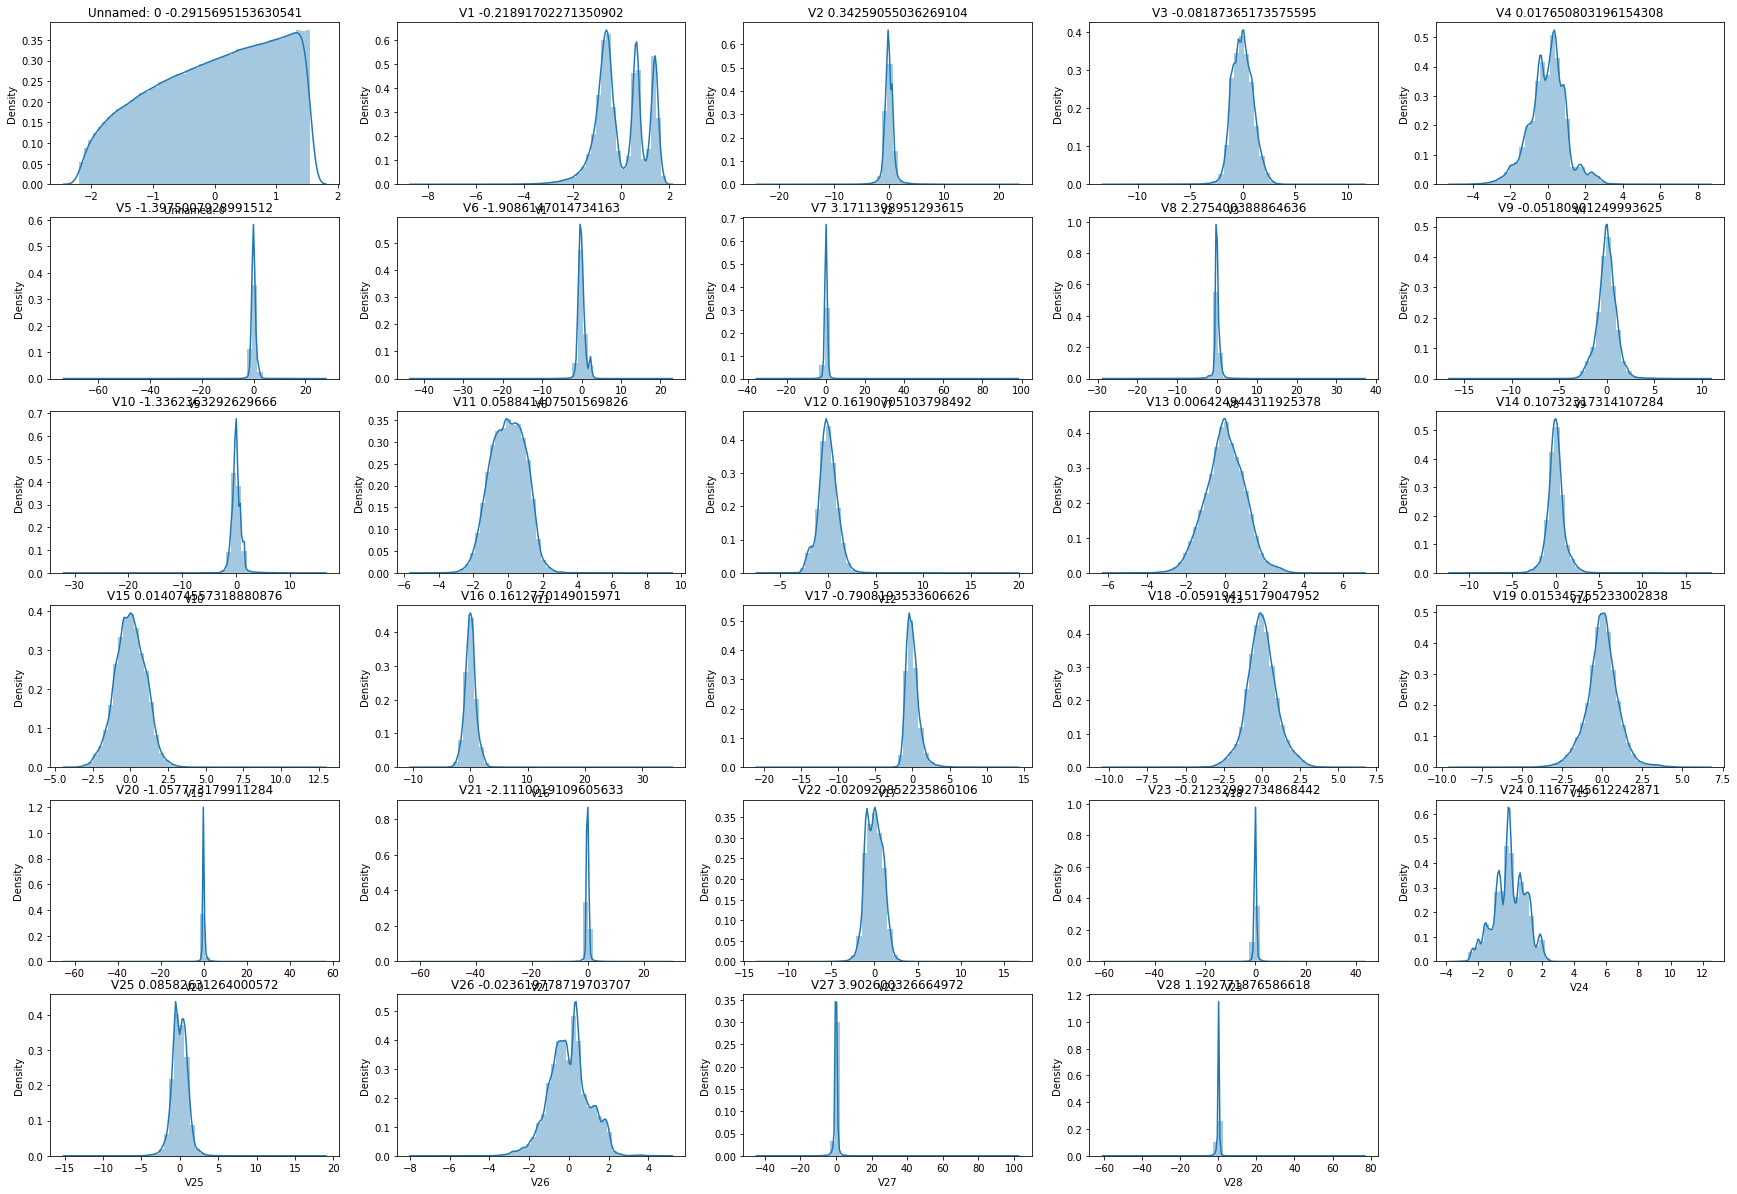

In [4]:
k = 0
plt.figure(figsize=(30,28))
for col in columns:    
    k += 1
    plt.subplot(8, 5,k)    
    sns.distplot(X_train[col])
    plt.title(col+' '+str(X_train[col].skew()))

In [11]:
def evaluate_model(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, train_res=True):
    if train_res:
        y_train_pred = model.predict(X_train)
        tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
        print("False Positive Rate: {}".format((fp / (fp + tn))))
        print("False Negative Rate: {}".format((fn / (tp + fn))))
        print("True Negative Rate (Specificity): {}".format((tn / (tn + fp))))
        print("True Positive Rate (Sensitivity/Recall): {}".format(metrics.recall_score(y_train, y_train_pred)))
        print("ROC-AUC Score: {}".format(metrics.roc_auc_score(y_train, y_train_pred)))
        print("Accuracy: {}".format(metrics.accuracy_score(y_train, y_train_pred)))
        print("Log-loss: {}".format(metrics.log_loss(y_train, y_train_pred)))
        print("F1 Score: {}".format(f1_score(y_train, y_train_pred)))
        print("F2 Score: {}".format(metrics.fbeta_score(y_train, y_train_pred, beta=2)))
        print(metrics.confusion_matrix(y_train, y_train_pred))
        print(classification_report(y_train, y_train_pred))
        
        print("------------------------------------------------------------------------------------")
    # Evaluation on Test Set
    y_test_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    print("False Positive Rate: {}".format((fp / (fp + tn))))
    print("False Negative Rate: {}".format((fn / (tp + fn))))
    print("True Negative Rate (Specificity): {}".format((tn / (tn + fp))))
    print("True Positive Rate (Sensitivity/Recall): {}".format(metrics.recall_score(y_test, y_test_pred)))
    print("ROC-AUC Score: {}".format(metrics.roc_auc_score(y_test, y_test_pred)))
    print("Accuracy: {}".format(metrics.accuracy_score(y_test, y_test_pred)))
    print("Log-loss: {}".format(metrics.log_loss(y_test, y_test_pred)))
    print("F1 Score: {}".format(f1_score(y_test, y_test_pred)))
    print("F2 Score: {}".format(metrics.fbeta_score(y_test, y_test_pred, beta=2)))
    print(metrics.confusion_matrix(y_test, y_test_pred))
    print(classification_report(y_test, y_test_pred))

    return None

Building a model on imbalanced Data

In [12]:
dt = DecisionTreeClassifier().fit(X_train, y_train)
evaluate_model(dt, train_res=False)

False Positive Rate: 0.0002638243984803715
False Negative Rate: 0.24528301886792453
True Negative Rate (Specificity): 0.9997361756015196
True Positive Rate (Sensitivity/Recall): 0.7547169811320755
ROC-AUC Score: 0.8772265783667975
Accuracy: 0.9992802219023208
Log-loss: 0.02486046533044569
F1 Score: 0.7960199004975125
F2 Score: 0.7707129094412332
[[56841    15]
 [   26    80]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56856
           1       0.84      0.75      0.80       106

    accuracy                           1.00     56962
   macro avg       0.92      0.88      0.90     56962
weighted avg       1.00      1.00      1.00     56962



In [13]:
rf = RandomForestClassifier().fit(X_train, y_train)
evaluate_model(rf, train_res=False)

False Positive Rate: 3.517658646404953e-05
False Negative Rate: 0.24528301886792453
True Negative Rate (Specificity): 0.999964823413536
True Positive Rate (Sensitivity/Recall): 0.7547169811320755
ROC-AUC Score: 0.8773409022728058
Accuracy: 0.9995084442259752
Log-loss: 0.016977763039437103
F1 Score: 0.851063829787234
F2 Score: 0.790513833992095
[[56854     2]
 [   26    80]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56856
           1       0.98      0.75      0.85       106

    accuracy                           1.00     56962
   macro avg       0.99      0.88      0.93     56962
weighted avg       1.00      1.00      1.00     56962



In [38]:
param_grid = {'max_depth': range(5,10,5),
            'min_samples_leaf': range(50, 150, 50),
            'min_samples_split': range(50, 150, 50),
            'n_estimators': [100,200,300]}   

model_cv = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    scoring="roc_auc",
    return_train_score=True
)

model_cv.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(5, 10, 5),
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50),
                         'n_estimators': [100, 200, 300]},
             return_train_score=True, scoring='roc_auc')

In [39]:
print(model_cv.best_params_)

{'max_depth': 5, 'min_samples_leaf': 100, 'min_samples_split': 100, 'n_estimators': 200}


In [14]:
rf = RandomForestClassifier(max_depth=5, min_samples_leaf=100, min_samples_split=100, n_estimators=200).fit(X_train, y_train)
evaluate_model(rf, train_res=False)

False Positive Rate: 0.00017588293232024765
False Negative Rate: 0.4056603773584906
True Negative Rate (Specificity): 0.9998241170676797
True Positive Rate (Sensitivity/Recall): 0.5943396226415094
ROC-AUC Score: 0.7970818698545945
Accuracy: 0.9990695551420246
Log-loss: 0.03213656727124442
F1 Score: 0.7039106145251396
F2 Score: 0.6338028169014085
[[56846    10]
 [   43    63]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56856
           1       0.86      0.59      0.70       106

    accuracy                           1.00     56962
   macro avg       0.93      0.80      0.85     56962
weighted avg       1.00      1.00      1.00     56962



In [15]:
ada = AdaBoostClassifier().fit(X_train, y_train)
evaluate_model(ada, train_res=False)

False Positive Rate: 0.00015829463908822287
False Negative Rate: 0.32075471698113206
True Negative Rate (Specificity): 0.9998417053609118
True Positive Rate (Sensitivity/Recall): 0.6792452830188679
ROC-AUC Score: 0.8395434941898898
Accuracy: 0.9992451107756047
Log-loss: 0.026073076460764854
F1 Score: 0.770053475935829
F2 Score: 0.7128712871287128
[[56847     9]
 [   34    72]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56856
           1       0.89      0.68      0.77       106

    accuracy                           1.00     56962
   macro avg       0.94      0.84      0.88     56962
weighted avg       1.00      1.00      1.00     56962



In [16]:
lr = LogisticRegression().fit(X_train, y_train)#+
evaluate_model(lr, train_res=False)

False Positive Rate: 0.00012311805262417335
False Negative Rate: 0.3867924528301887
True Negative Rate (Specificity): 0.9998768819473758
True Positive Rate (Sensitivity/Recall): 0.6132075471698113
ROC-AUC Score: 0.8065422145585935
Accuracy: 0.9991573329588147
Log-loss: 0.029104786772546274
F1 Score: 0.7303370786516854
F2 Score: 0.655241935483871
[[56849     7]
 [   41    65]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56856
           1       0.90      0.61      0.73       106

    accuracy                           1.00     56962
   macro avg       0.95      0.81      0.86     56962
weighted avg       1.00      1.00      1.00     56962

